# Lab. 7 - PCA and variable selection (Moses Mbabaali 4846019) 

In this lab we will move to considering the problems of dimensionality reduction in unsupervised settings, and variable selection in classification (thus supervised) scenarios.

As usual, we start importing libraries and functions already used in one of the previous labs.

In [7]:
# import libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy.linalg as la

In [8]:
def mixGauss(means, sigmas, n):

    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2,
                                                                    size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

##### Data generation

To generate a synthetic dataset suitable for use with PCA and variable selection, we first generate a subset of "relevant" features, and then concatenate with a second set of "dummy" featuers. To this purpose,  we proceed as follows:
- Generate a dataset with mixGauss using two Gaussians "close" with each other (see example below). Let's start considering 2-Dimensional points 
- Plot the points: you should observe an "elongated" points cloud
- Enrich the input samples with "dummy" variables randomly sampled and concatenate to the relevant features (notice that at this point data visualization is no more possible


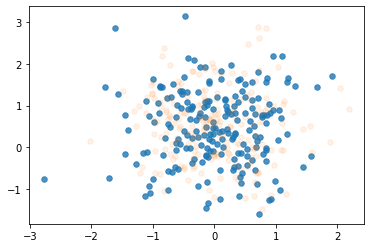

In [9]:
n=100 # number of features for each gaussian
d=30 # total number of features
d_rev = 2 # number of relevant features

Xtr, Ytr = mixGauss(means = [[0,0],[0,1]], sigmas = [0.7, 0.7], n=100)
Ytr[Ytr==2]=-1
Xte, Yte = mixGauss(means = [[0,0],[0,1]], sigmas = [0.7, 0.7], n=100)
Yte[Yte==2]=-1

# plot
plt.scatter(Xtr[:,0], Xtr[:,1], s=30, alpha=0.80)
plt.scatter(Xte[:,0], Xte[:,1], s=30, alpha=0.10)

# dummy features generation
sigma_noise = 0.01
Xtr_noise = sigma_noise * np.random.randn(d_rev*n, d-d_rev)
Xtr = np.concatenate((Xtr,Xtr_noise), axis=1)
Xte_noise = sigma_noise * np.random.randn(d_rev*n, d-d_rev)
Xte = np.concatenate((Xte,Xte_noise), axis=1)

### Principal Component Analysis

##### explainedVariance
Given a set of eigenvalues, sorted in decreasing order, the function returns the cumulative explained variance 

In [10]:
def explainedVariance(eig_vals):
    
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in eig_vals]
    cum_var_exp = np.cumsum(var_exp)
    
    return cum_var_exp

In [11]:
explainedVariance([1,2,3,3,4,5,8])

array([  3.84615385,  11.53846154,  23.07692308,  34.61538462,
        50.        ,  69.23076923, 100.        ])

##### PCA

Given a data matrix and a positive number k, the function computes the first k eigenvectors of the covariance matrix. It returns the Principal Components and the Cumulative Explained Variance.

In [97]:
def PCA(X, k):
   
    # standardize the data
    mean = X.mean(axis=0)
    X_z = X - mean
    
    # Compute the covariance matrix of X_z
    cov_mat = np.cov(X_z.T)
    
    # compute eigenvalues and eigenvectors of the covariance matrix
    eigvals, eigvec = np.linalg.eig(cov_mat)
    
    # sort the eigenvalues in decreasing order and obtain the corresponding indexes
    eigvec = eigvec.T
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvec = eigvec[idx]
    # select the first k eigenvectors (Principal Components)
    PC = eigvec[0:k]
    # compute the Cumulative Explained Variance
    
    #total = sum(eigvals)
    #var_expected = [(i/total)*100 for i in eigvals]
    #expl_var = np.cumsum(var_expected)
    expl_var = explainedVariance(eigvals)
    
    
    return PC, expl_var


##### PCA_Project

Given a matrix and the Principal Components, it returns the projected points

In [99]:
def PCA_Project(X, PC):

    # standardize the data
    mean = X.mean(axis=0)
    X_z = X - mean
    
    # obtain the projected points
    
    #X_proj = np.dot(X_z,PC)
    X_proj = np.dot(X_z,PC.T)
    
    return X_proj

In [100]:
PCA_Project(Xtr,PCA(Xtr, 5)[0]).shape

(200, 5)

#### Some analysis

We suggest to do the following:
- Run PCA on the training set
- Project the points
- Plot the Cumulative Explained Variance: what can you notice?
- Plot the projected points: how do they look?

Next, try the previous step as you
- Increase the standard deviation (sigma_noise) when you generate dummy features
- Increase the number of relevant features



Text(0, 0.5, 'Cumulative explained variance')

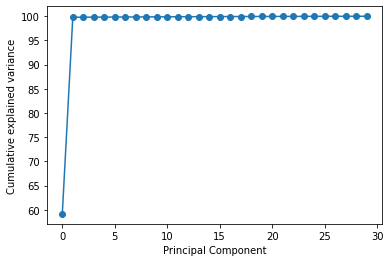

In [101]:
PC, expl_var = PCA(Xtr, 5)
X_proj = PCA_Project(Xtr,PCA(Xtr, 5)[0])
pcidx = np.arange(len(expl_var))

plt.plot(pcidx, expl_var, '-o')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative explained variance')

#The cummulative explained variance increases as the the number of components increase 

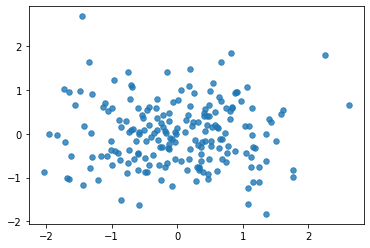

In [102]:
plt.scatter(X_proj[:,0], X_proj[:,1], s=30, alpha=0.80)

Text(0, 0.5, 'Cumulative explained variance')

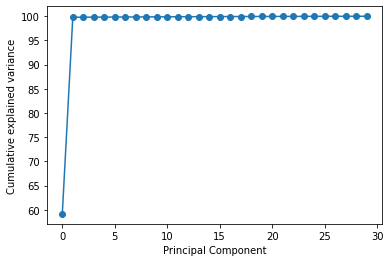

In [104]:
PC1, expl_var1 = PCA(Xtr, 10)
X_proj = PCA_Project(Xtr,PCA(Xtr, 10)[0])
pcidx1 = np.arange(len(expl_var1))

plt.plot(pcidx1, expl_var1, '-o')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative explained variance')

#The cummulative explained variance increases as the the number of components increase but then stays constant after
#it hits more than 3 features. 

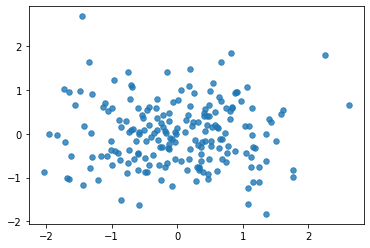

In [105]:
plt.scatter(X_proj[:,0], X_proj[:,1], s=30, alpha=0.80)

## Variable selection

##### OMatchingPursuit

It computes a sparse representation of the signal using Orthogonal Matching Pursuit algorithm. Use it as follows:
    
#### w, r, I = OMatchingPursuit( X, Y, T)
where
    - X: input data
    - Y: output labels
    - T: number of iterations
    - w: estimated coefficients
    - r: residuals
    - I: indices
    
HAVE A LOOK AT THE CODE AND TRY TO USE IT (MORE DETAILS ON MONDAY...)

In [106]:
def OMatchingPursuit(X, Y, T):
   
    N, D = np.shape(X)

    # Initialization of residual, coefficient vector and index set I
    r = Y
    w = np.zeros(D)
    I = []

    for i in range(T):
        I_tmp = range(D)

        # Select the column of X which most "explains" the residual
        a_max = -1

        for j in I_tmp:
            a_tmp = ((r.T.dot(X[:, j])) ** 2) / (X[:, j].T.dot(X[:, j]))

            if a_tmp > a_max:
                a_max = a_tmp
                j_max = j

        # Add the index to the set of indexes
        if np.sum(I == j_max) == 0:
            I.append(j_max)

        # Compute the M matrix
        M_I = np.zeros((D, D))

        for j in I:
            M_I[j, j] = 1

        A = M_I.dot(X.T).dot(X).dot(M_I)
        B = M_I.dot(X.T).dot(Y)

        # Update estimated coefficients
        w = np.linalg.pinv(A).dot(B)

        # Update the residual
        r = Y - X.dot(w)

    return w, r, I

In [107]:
# Usual function to compute the error in predicted labels (for a binary classification problem)
def calcError(Ypred, Y):

    V=np.multiply(np.sign(Ypred),np.sign(Y) )
    return np.count_nonzero(V<0)/len(Y)

In [108]:
# K-Fold Cross Validation for selecting the best value for the hyperparameters in the use of Orthogonal 
# Matching Pursuit (we refer to the number of iterations)

def KFoldCVOMP(Xtr, Ytr, KF, niter_list):

    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    # Ensures that k_list is a numpy array
    niter_list = np.array(niter_list)
    num_niter = niter_list.size

    n_tot = Xtr.shape[0]
    n_val = int(np.floor(n_tot/KF))

    Tm = np.zeros(num_niter)
    Ts = np.zeros(num_niter)
    Vm = np.zeros(num_niter)
    Vs = np.zeros(num_niter)

    # Random permutation of training data
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    
    
    for kdx, niter in enumerate(niter_list):
        first = 0
        for fold in range(KF):
           
            flags = np.zeros(Xtr.shape[0])
            flags[first:first+n_val]=1;
            
            X = Xtr[rand_idx[flags==0]]
            Y = Ytr[rand_idx[flags==0]]
            X_val = Xtr[rand_idx[flags==1]]
            Y_val = Ytr[rand_idx[flags==1]]

            # Compute the training error of the RLS regression for the given value of regpar
            w, r, I = OMatchingPursuit(X, Y, niter)
            YpredTR = np.sign(X.dot(w))
            trError = calcError(YpredTR, Y)
            Tm[kdx] = Tm[kdx] + trError
            Ts[kdx] = Ts[kdx] + trError ** 2

            # Compute the validation error of the RLS regression for the given value of regpar
            YpredVAL = np.sign(X_val.dot(w))
            valError = calcError(YpredVAL, Y_val)
            Vm[kdx] = Vm[kdx] + valError
            Vs[kdx] = Vs[kdx] + valError ** 2
            
            first = first+n_val                

    Tm = Tm / KF
    Ts = Ts / KF - Tm ** 2

    Vm = Vm / KF
    Vs = Vs / KF - Vm ** 2

    best_niter_idx = np.argmin(Vm)
    bestniter = niter_list[best_niter_idx]
    
    print(Vm)
    print(niter_list)
    print(best_niter_idx)

    return bestniter, Vm, Vs, Tm, Ts

#### Some analysis

We suggest to proceed as follows:

- Standardize the data
- Run Orthogonal Matching Pursuit on the training set setting a reasonable number of iterations
- Compute the prediction on the test set and evaluate the error
- Plot the components of the solution w (considering their absolute value): how do they look?
- Run the K-Fold Cross Validation to select an appropriate value for the number of iterations

Test error is : 0.245


/home/mb/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


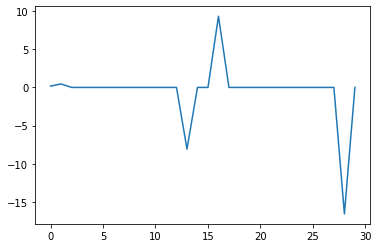

In [109]:
#No algorithm was mentioned to use in this exercise for the prediction problem for the test set so i have chosen
# to use logistic regression from sklearn
from sklearn.linear_model import LogisticRegression

# Data standardization
m = np.mean(Xtr, axis=0)
s = np.std(Xtr, axis=1)
s = np.reshape(s, (len(s),1))
Xtrnorm = np.divide((Xtr-m), s)
Xtenorm = np.divide((Xte-m), s)

# Run Orthogonal Matching Pursuit
w, r, I = OMatchingPursuit( Xtr, Ytr, 5)

# Compute the prediction on the test set
clf = LogisticRegression(random_state=0).fit(Xtr, Ytr)
Ypred = clf.predict(Xte)

# Compute the test error and show its value
TestError = calcError(Ypred, Ytr)
print ('Test error is : '+str(TestError))


# Plot the components of the solution w
plt.plot(w)

[0.265 0.305 0.305 0.305 0.33  0.33  0.325 0.35  0.36  0.38  0.37  0.38
 0.365 0.345 0.375 0.355 0.355 0.38  0.365 0.375 0.365 0.35  0.37  0.365
 0.38  0.39  0.395 0.385 0.38 ]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
0


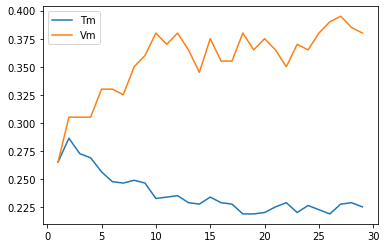

Best number of iterations: 1


In [110]:
# Define an appropriate range of possible iterations number and run K-Fold Cross Validation
KF = 5
niter_list = [i for i in range(1,30)]
bestniter, Vm, Vs, Tm, Ts = KFoldCVOMP(Xtr, Ytr, KF, niter_list)

# Plot training and validation error
plt.plot(niter_list, Tm, label = 'Tm')
plt.plot(niter_list, Vm, label = 'Vm')
plt.legend()
plt.show()
print('Best number of iterations: '+str(bestniter))